In [139]:
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import avg, col, concat, desc, explode, lit, split, udf, isnull, isnan, to_date, hour, current_date,datediff
from pyspark.sql.functions import sum as fsum
from pyspark.sql.functions import max as fmax
from pyspark.sql.types import IntegerType
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import datetime
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
# instantiate a Spark session
spark = SparkSession.builder \
    .master('local') \
    .appName('sparkify') \
    .getOrCreate()

# Load and Explore dataset
### Load the dataset

In [3]:
# load the user log data 
data_path = 'medium_sparkify_event_data.json'
df = spark.read.json(data_path)

In [4]:
# preview its general information
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# take a look at the content of first 3 rows 
df.take(3)

[Row(artist='Martin Orford', auth='Logged In', firstName='Joseph', gender='M', itemInSession=20, lastName='Morales', length=597.55057, level='free', location='Corpus Christi, TX', method='PUT', page='NextSong', registration=1532063507000, sessionId=292, song='Grand Designs', status=200, ts=1538352011000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"', userId='293'),
 Row(artist="John Brown's Body", auth='Logged In', firstName='Sawyer', gender='M', itemInSession=74, lastName='Larson', length=380.21179, level='free', location='Houston-The Woodlands-Sugar Land, TX', method='PUT', page='NextSong', registration=1538069638000, sessionId=97, song='Bulls', status=200, ts=1538352025000, userAgent='"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"', userId='98'),
 Row(artist='Afroman', auth='Logged In', firstName='Maverick', gender='M', 

In [6]:
# row numbers
df.count()

543705

In [7]:
# any duplicated log
df.dropDuplicates().count()

543705

### Explore the user log data

In [8]:
# data types in dataset
df.dtypes

[('artist', 'string'),
 ('auth', 'string'),
 ('firstName', 'string'),
 ('gender', 'string'),
 ('itemInSession', 'bigint'),
 ('lastName', 'string'),
 ('length', 'double'),
 ('level', 'string'),
 ('location', 'string'),
 ('method', 'string'),
 ('page', 'string'),
 ('registration', 'bigint'),
 ('sessionId', 'bigint'),
 ('song', 'string'),
 ('status', 'bigint'),
 ('ts', 'bigint'),
 ('userAgent', 'string'),
 ('userId', 'string')]

In [9]:
print(f'There are in total {len(df.dtypes)} columns in the dataset')
# how many categorical and numerical columns
cat_cols = []
num_cols = []

for i in range(len(df.dtypes)):
    if df.dtypes[i][1] == 'string':
        cat_cols.append(df.dtypes[i][0])
    else:
        num_cols.append(df.dtypes[i][0])
        
print(f'Categorical columns: {cat_cols}')
print(f'Numerical columns: {num_cols}')

There are in total 18 columns in the dataset
Categorical columns: ['artist', 'auth', 'firstName', 'gender', 'lastName', 'level', 'location', 'method', 'page', 'song', 'userAgent', 'userId']
Numerical columns: ['itemInSession', 'length', 'registration', 'sessionId', 'status', 'ts']


What are the values in each columns?
Considering the effectiveness of the models we will build, we will take a look at the values of those columns(features) which will help us in the next cleaning data step.   

1.Descriptive statistics of numeric columns

In [10]:
# item number in session
df.describe('itemInSession').show()

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            543705|
|   mean|107.30629109535502|
| stddev|116.72350849187941|
|    min|                 0|
|    max|              1005|
+-------+------------------+



In [11]:
# length of time for specific log
df.describe('length').show()

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|            432877|
|   mean|248.66459278007807|
| stddev| 98.41266955052018|
|    min|           0.78322|
|    max|        3024.66567|
+-------+------------------+



In [12]:
# users registration number
df.describe('registration').show()

+-------+--------------------+
|summary|        registration|
+-------+--------------------+
|  count|              528005|
|   mean|1.535523414862806...|
| stddev|3.0787254929942865E9|
|    min|       1509854193000|
|    max|       1543073874000|
+-------+--------------------+



In [13]:
# Session ID
df.describe('sessionId').show()

+-------+------------------+
|summary|         sessionId|
+-------+------------------+
|  count|            543705|
|   mean|2040.8143533717732|
| stddev|1434.3389310782754|
|    min|                 1|
|    max|              4808|
+-------+------------------+



In [14]:
# Web status (200 for OK, etc.)
df.describe('status').show()

+-------+------------------+
|summary|            status|
+-------+------------------+
|  count|            543705|
|   mean|210.01829116892432|
| stddev| 31.47191902156764|
|    min|               200|
|    max|               404|
+-------+------------------+



In [15]:
# ts: timestamp of current log
df.describe('ts').show()

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              543705|
|   mean|1.540964541209808E12|
| stddev|1.4820571448945475E9|
|    min|       1538352011000|
|    max|       1543622466000|
+-------+--------------------+



2. Values in some categorical column.

In [16]:
# artist
df.groupBy('artist').count().show()

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|      The Black Keys| 2160|
|        Yann Tiersen|  295|
|    Jane's Addiction|  151|
|          Tim Hughes|   54|
|Dashboard Confess...|  206|
|                Silk|   37|
|Yonder Mountain S...|  126|
|            La Shica|    1|
|        Elvis Crespo|    8|
|         Silverstein|   92|
|         Eva Cassidy|   78|
|        Generation X|   35|
|     Robyn Hitchcock|    8|
|           Kate Nash|  161|
|       Jupiter Jones|   11|
|           Los Lobos|   74|
|               Rufio|   24|
|     Drive Like Jehu|    1|
|       Yuichi Tamate|    7|
|      Jarabe De Palo|  142|
+--------------------+-----+
only showing top 20 rows



In [17]:
df.groupBy('artist').count().sort('artist').show()

+--------------------+------+
|              artist| count|
+--------------------+------+
|                null|110828|
|                 !!!|    26|
|        & And Oceans|     2|
|        '68 Comeback|     3|
|'N Sync/Phil Collins|     8|
|        'Til Tuesday|     7|
|'t Hof Van Commer...|     2|
|       (Love) Tattoo|     2|
|          (hed) p.e.|     7|
|*NSYNC featuring ...|     1|
|  + / - {Plus/Minus}|    40|
|                 +44|    74|
|          -123 minut|     1|
|            -123min.|     4|
|                 -M-|     3|
|       ...And Oceans|     1|
|...And You Will K...|    16|
|           1 40 4 20|     3|
|1 Giant Leap feat...|     3|
|1 Giant Leap feat...|     7|
+--------------------+------+
only showing top 20 rows



In [18]:
# auth : whether or not the user is logged in
df.groupBy('auth').count().show()

+----------+------+
|      auth| count|
+----------+------+
|Logged Out| 15606|
| Cancelled|    99|
|     Guest|    94|
| Logged In|527906|
+----------+------+



In [19]:
# gender : gender of the user
df.groupBy('gender').count().show()

+------+------+
|gender| count|
+------+------+
|     F|225393|
|  null| 15700|
|     M|302612|
+------+------+



In [20]:
# level : user level
df.groupBy('level').count().show()

+-----+------+
|level| count|
+-----+------+
| free|115108|
| paid|428597|
+-----+------+



In [21]:
# location : physical location of user
df.groupBy('location').count().sort('count',ascending=False).show(truncate=False)

+-------------------------------------------+-----+
|location                                   |count|
+-------------------------------------------+-----+
|New York-Newark-Jersey City, NY-NJ-PA      |40156|
|Los Angeles-Long Beach-Anaheim, CA         |34278|
|Boston-Cambridge-Newton, MA-NH             |17574|
|null                                       |15700|
|Chicago-Naperville-Elgin, IL-IN-WI         |15194|
|San Francisco-Oakland-Hayward, CA          |11428|
|Atlanta-Sandy Springs-Roswell, GA          |11211|
|Phoenix-Mesa-Scottsdale, AZ                |11184|
|Dallas-Fort Worth-Arlington, TX            |11061|
|Denver-Aurora-Lakewood, CO                 |9808 |
|Houston-The Woodlands-Sugar Land, TX       |8707 |
|Tampa-St. Petersburg-Clearwater, FL        |8330 |
|Miami-Fort Lauderdale-West Palm Beach, FL  |8180 |
|Indianapolis-Carmel-Anderson, IN           |7691 |
|Minneapolis-St. Paul-Bloomington, MN-WI    |7462 |
|Louisville/Jefferson County, KY-IN         |7457 |
|Fresno, CA 

In [22]:
# check any null value
df.groupBy('location').count().sort('location').show()

+--------------------+-----+
|            location|count|
+--------------------+-----+
|                null|15700|
|           Akron, OH|  223|
|          Albany, OR| 1303|
|Albany-Schenectad...|  307|
|       Albemarle, NC| 6019|
|      Alexandria, LA| 2020|
|      Alexandria, MN| 1013|
|Allentown-Bethleh...| 2617|
|       Anchorage, AK| 1668|
|        Appleton, WI| 6184|
|          Athens, TX|   13|
|Atlanta-Sandy Spr...|11211|
|Atlantic City-Ham...| 2532|
|          Auburn, IN|  825|
|Augusta-Watervill...|  321|
|Austin-Round Rock...| 4807|
|     Bakersfield, CA| 4740|
|Baltimore-Columbi...| 1911|
|Beaumont-Port Art...|   33|
|      Big Spring, TX| 1456|
+--------------------+-----+
only showing top 20 rows



In [23]:
# method : requests(web calls)
df.groupBy('method').count().show()

+------+------+
|method| count|
+------+------+
|   PUT|495143|
|   GET| 48562|
+------+------+



In [24]:
# page : which page are users on in the site
df.groupBy('page').count().sort('count', ascending=False).show(n=df.select('page').distinct().count(), truncate=False)

+-------------------------+------+
|page                     |count |
+-------------------------+------+
|NextSong                 |432877|
|Home                     |27412 |
|Thumbs Up                |23826 |
|Add to Playlist          |12349 |
|Add Friend               |8087  |
|Roll Advert              |7773  |
|Login                    |6011  |
|Logout                   |5990  |
|Thumbs Down              |4911  |
|Downgrade                |3811  |
|Help                     |3150  |
|Settings                 |2964  |
|About                    |1855  |
|Upgrade                  |968   |
|Save Settings            |585   |
|Error                    |519   |
|Submit Upgrade           |287   |
|Submit Downgrade         |117   |
|Cancel                   |99    |
|Cancellation Confirmation|99    |
|Register                 |11    |
|Submit Registration      |4     |
+-------------------------+------+



In [25]:
# userAgent: Type of browser user is on
df.groupBy('userAgent').count().sort('count', ascending=False).show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------+-----+
|userAgent                                                                                                                                  |count|
+-------------------------------------------------------------------------------------------------------------------------------------------+-----+
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"                 |46082|
|Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0                                                                   |39456|
|"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.143 Safari/537.36"                            |38551|
|"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/36.0.1985.125 Safari/537.36"

In [26]:
df.groupBy('userAgent').count().sort('userAgent').show(n=5, truncate=False)

+--------------------------------------------------------------------------------------------------------------------------+-----+
|userAgent                                                                                                                 |count|
+--------------------------------------------------------------------------------------------------------------------------+-----+
|null                                                                                                                      |15700|
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10) AppleWebKit/600.1.3 (KHTML, like Gecko) Version/8.0 Safari/600.1.3"        |1800 |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10) AppleWebKit/600.1.8 (KHTML, like Gecko) Version/8.0 Safari/600.1.8"        |5566 |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.94 Safari/537.36"|3793 |
|"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8) AppleWebKit/534.59.10 (KHTML, like

In [27]:
# status: web status(200 for OK)
df.groupBy('status').count().sort('count', ascending=False).show()

+------+------+
|status| count|
+------+------+
|   200|493269|
|   307| 49917|
|   404|   519|
+------+------+



In [28]:
# userId : userID for user
# number of unique users
df.select('userId').distinct().count()

449

In [29]:
# values in userId
df.groupBy('userId').count().sort('userId').show()

+------+-----+
|userId|count|
+------+-----+
|      |15700|
|    10|  423|
|   100| 3999|
|100001|  134|
|100002|  177|
|100003|  827|
|100004|  373|
|100005|  100|
|100006|  375|
|100007| 1052|
|100008|  463|
|100009| 2987|
|100010|  137|
|100011| 1303|
|100012|  167|
|100013|   27|
|100014|  406|
|100015|  529|
|100016|  200|
|100017|  178|
+------+-----+
only showing top 20 rows



**Observations in data exploration:**   
1. No duplicated user log record in this dataset;   
2. Missing values exist in several columns(artist, gender, length, location, registration, userAgent), we need to take further cleaning step if we use them in the model building process;   
3. userId has the empty string as a value, we need to take further cleaning step if we use them in the model building process;   
4. There are 448 unique userID in this dataset;   
5. The datatype of timestamp of the current song and registration could be transformed into date or other type, which provide more information about the user behavior.

# Clean the dataset



In [30]:
# define a function to check missing or invalid data in each column 
# https://www.xspdf.com/resolution/58823266.html
# https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.isnan
def check_na(df):
    '''
       Returns the counts of missing values per column
    '''
    for col in df.columns:
        counts_miss = df.filter(isnull(df[col])| isnan(df[col])| (df[col] == '')).count()
        print(f'{col} : {counts_miss}')

In [31]:
check_na(df)

artist : 110828
auth : 0
firstName : 15700
gender : 15700
itemInSession : 0
lastName : 15700
length : 110828
level : 0
location : 15700
method : 0
page : 0
registration : 15700
sessionId : 0
song : 110829
status : 0
ts : 0
userAgent : 15700
userId : 15700


Since the invalid userId counts not much(nearly 3%) of the total records, we decided to drop them.

In [32]:
# drop those missing and invalid records when userId is invalid
for c in df.columns:
    df_valid = df.filter(~isnull(df[c])& ~isnan(df[c])& (df[c] != ''))
check_na(df_valid)

artist : 95128
auth : 0
firstName : 0
gender : 0
itemInSession : 0
lastName : 0
length : 95128
level : 0
location : 0
method : 0
page : 0
registration : 0
sessionId : 0
song : 95129
status : 0
ts : 0
userAgent : 0
userId : 0


Now we still have 95129 missing data points in artist, length and song columns.Those are all data revelent to song played.This is because the fact that the nature of this dataset is the user log data,which contains all kinds of user behavior(not just focusing on listening songs). 

In [33]:
# convert the timestamp() into data in ts column
# https://stackoverflow.com/questions/45977449/convert-timestamp-to-date-in-spark-dataframe
# https://sparkbyexamples.com/spark/spark-convert-timestamp-to-date/
df_valid = df_valid.withColumn('date', to_date((col('ts')/1000).cast('timestamp'))).withColumn('registration_date', to_date((col('registration')/1000).cast('timestamp')))
df_valid.show(1)

+-------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------+-------------+--------------------+------+----------+-----------------+
|       artist|     auth|firstName|gender|itemInSession|lastName|   length|level|          location|method|    page| registration|sessionId|         song|status|           ts|           userAgent|userId|      date|registration_date|
+-------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------+-------------+--------------------+------+----------+-----------------+
|Martin Orford|Logged In|   Joseph|     M|           20| Morales|597.55057| free|Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|2018-10-01|       2018-07-20|
+-------------+---------+---------+------+-------------+--------+---

In [34]:
# convert the timestamp into datetime
# https://sparkbyexamples.com/spark/spark-extract-hour-minute-and-second-from-timestamp/
df_valid = df_valid.withColumn('time', hour((col('ts')/1000).cast('timestamp')))
df_valid.select('time').distinct().show()

+----+
|time|
+----+
|  12|
|  22|
|   1|
|  13|
|   6|
|  16|
|   3|
|  20|
|   5|
|  19|
|  15|
|   9|
|  17|
|   4|
|   8|
|  23|
|   7|
|  10|
|  21|
|  11|
+----+
only showing top 20 rows



In [35]:
# add a state column according to the location column
# https://www.datasciencemadesimple.com/string-split-of-the-columns-in-pyspark/
df_valid = df_valid.withColumn('state', split(col('location'), ',').getItem(1))
df_valid.show(1)

+-------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------+-------------+--------------------+------+----------+-----------------+----+-----+
|       artist|     auth|firstName|gender|itemInSession|lastName|   length|level|          location|method|    page| registration|sessionId|         song|status|           ts|           userAgent|userId|      date|registration_date|time|state|
+-------------+---------+---------+------+-------------+--------+---------+-----+------------------+------+--------+-------------+---------+-------------+------+-------------+--------------------+------+----------+-----------------+----+-----+
|Martin Orford|Logged In|   Joseph|     M|           20| Morales|597.55057| free|Corpus Christi, TX|   PUT|NextSong|1532063507000|      292|Grand Designs|   200|1538352011000|"Mozilla/5.0 (Mac...|   293|2018-10-01|       2018-07-20|   2|   TX|
+-------------+---------

In [36]:
# drop unrelevent columns
df_valid = df_valid.drop('userAgent', 'method','registration', 'status', 'userAgent')

In [37]:
df_valid.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- page: string (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- userId: string (nullable = true)
 |-- date: date (nullable = true)
 |-- registration_date: date (nullable = true)
 |-- time: integer (nullable = true)
 |-- state: string (nullable = true)



In [38]:
df_valid.count()

528005

In this stage, we get the clean dataset with valid data and add two coulmns about the time and date for later modeling.There are 528005 rows in clean dataset.

# Data Analysis

### Define Churn   

Once we've done the preliminary analysis, we need to define the churn used as the label for our model. According to the above information, we could use "Cancellation Confirmation" and "Downgrade" events to define the churn, which happened for both paid and free users.

In [39]:
# take a look at rows when pages are cancellation conformation
df_valid.select(['auth', 'gender', 'itemInSession', 'level', 'location', 'page', 'sessionId', 'userId', 'date', 'time']).where(df_valid['page']=='Cancellation Confirmation').show()

+---------+------+-------------+-----+--------------------+--------------------+---------+------+----------+----+
|     auth|gender|itemInSession|level|            location|                page|sessionId|userId|      date|time|
+---------+------+-------------+-----+--------------------+--------------------+---------+------+----------+----+
|Cancelled|     F|           40| free|      Fort Wayne, IN|Cancellation Conf...|      490|   208|2018-10-01|  15|
|Cancelled|     F|          234| paid|        Columbus, OH|Cancellation Conf...|      471|   231|2018-10-02|  14|
|Cancelled|     M|          109| paid|Grand Rapids-Wyom...|Cancellation Conf...|      682|   236|2018-10-03|   6|
|Cancelled|     M|           66| free|   Bowling Green, KY|Cancellation Conf...|      628|   156|2018-10-03|  20|
|Cancelled|     M|          227| paid|         Roanoke, VA|Cancellation Conf...|      395|   271|2018-10-05|  22|
|Cancelled|     M|          193| paid|Seattle-Tacoma-Be...|Cancellation Conf...|      86

The auth column is full with "Cancelled". It confirms that whenever user is in "Cancellation Confirmation" page, the user cancels the auth. 

In [40]:
df_valid.filter((df_valid.auth != 'Cancelled') & (df_valid.page == 'Cancellation Confirmation')).count()

0

It confirms the relationship between auth = 'Cancelled' and page = 'Cancellation Confirmation', so either of them can define churn.

In [41]:
# userId 208 user behavior before churning and after churning
df_valid.select(['auth', 'gender', 'song', 'level', 'page', 'sessionId', 'userId', 'date', 'time']).where((df_valid.userId == 208) & (df_valid.time >= 15 )).show()

+---------+------+--------------------+-----+--------------------+---------+------+----------+----+
|     auth|gender|                song|level|                page|sessionId|userId|      date|time|
+---------+------+--------------------+-----+--------------------+---------+------+----------+----+
|Logged In|     F|I'll Try Anything...| free|            NextSong|      490|   208|2018-10-01|  15|
|Logged In|     F|Horn Concerto No....| free|            NextSong|      490|   208|2018-10-01|  15|
|Logged In|     F|Nothing Better (A...| free|            NextSong|      490|   208|2018-10-01|  15|
|Logged In|     F|Do You Believe In...| free|            NextSong|      490|   208|2018-10-01|  15|
|Logged In|     F|          Hasta Ayer| free|            NextSong|      490|   208|2018-10-01|  15|
|Logged In|     F|Must Be Doin' Som...| free|            NextSong|      490|   208|2018-10-01|  15|
|Logged In|     F|             Revelry| free|            NextSong|      490|   208|2018-10-01|  15|


When user 208 confirmed the cancellation, there is no user log any more which means he/she stopped using Sparkify.

In [42]:
# take a look at rows when pages are Submit Downgrade
df_valid.select(['auth', 'gender', 'itemInSession', 'level', 'location', 'page', 'sessionId', 'userId', 'date', 'time']).where(df_valid['page']=='Submit Downgrade').show()

+---------+------+-------------+-----+--------------------+----------------+---------+------+----------+----+
|     auth|gender|itemInSession|level|            location|            page|sessionId|userId|      date|time|
+---------+------+-------------+-----+--------------------+----------------+---------+------+----------+----+
|Logged In|     M|          117| paid|Chicago-Napervill...|Submit Downgrade|      287|   288|2018-10-01|  10|
|Logged In|     F|          105| paid|Dallas-Fort Worth...|Submit Downgrade|      537|   127|2018-10-02|   4|
|Logged In|     M|           10| paid|Chicago-Napervill...|Submit Downgrade|      723|   174|2018-10-03|  10|
|Logged In|     M|          127| paid|Houston-The Woodl...|Submit Downgrade|      826|     6|2018-10-05|  14|
|Logged In|     M|          125| paid|  Corpus Christi, TX|Submit Downgrade|      899|   293|2018-10-05|  16|
|Logged In|     F|          142| paid|      Pittsburgh, PA|Submit Downgrade|      393|   145|2018-10-05|  21|
|Logged In

In [43]:
# userId 6 user behavior before downgrading and after downgrading
df_valid.select(['userId', 'song', 'level', 'page', 'sessionId', 'date', 'time']).where((df_valid.userId == 6) & (df_valid.time >= 14) & (df_valid.time <= 15)).show()

+------+--------------------+-----+----------------+---------+----------+----+
|userId|                song|level|            page|sessionId|      date|time|
+------+--------------------+-----+----------------+---------+----------+----+
|     6|      Drop The World| paid|        NextSong|      826|2018-10-05|  14|
|     6|       All My Senses| paid|        NextSong|      826|2018-10-05|  14|
|     6|                 Sin| paid|        NextSong|      826|2018-10-05|  14|
|     6|Ocean Breathes Salty| paid|        NextSong|      826|2018-10-05|  14|
|     6|             Society| paid|        NextSong|      826|2018-10-05|  14|
|     6|                null| paid|       Thumbs Up|      826|2018-10-05|  14|
|     6|                null| paid| Add to Playlist|      826|2018-10-05|  14|
|     6|         Bittersweet| paid|        NextSong|      826|2018-10-05|  14|
|     6|           GissiÃÂ©| paid|        NextSong|      826|2018-10-05|  14|
|     6|                null| paid|       Downgrade|

When the user is in the page "Submit Downgrade", his/her level changed from the paid user to a free user which means he or she churned the paid service but still using the Sparkify as a free user.  

Now we could define the user churning into 2 ways, churning product(stop using Sparkify) and churning serive(unsubscribe the paid service). We decided to use both of them as the user churning to predict the risk of stopping using Sparkify or cancel the subsciption in Sparkify. 

In [44]:
def churn_label(df, page_status, phase_name, label_name):
    '''
    Add the churn label column to dataframe.The value of this label column is either 0 or 1.
    
    Arguments:
        df: the dataframe of interest
        page_status: "Submit Downgrade" or "Cancellation Confirmation", the sign of user churning activity
        phase_name: the name of the column which indicates the phase status
        label_name: the name of the column which indicates churning status
        
    Output:
        return the dataframe with the label column
    '''
    # check the churning event and add the column with event corresponding name 
    churn_event = udf(lambda x: 1 if x == page_status else 0, IntegerType())
    df_event = df.withColumn(page_status, churn_event('page'))
    
    # add phase column to see the change of status when user churned mutiple times
    # use window function to compute rows with all preceding rows in reverse order for specific user
    windowval = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)
    df_phase = df_event.withColumn(phase_name, fsum(page_status).over(windowval))
    
    # add the churn label column according to corresponding page status for each user
    df_label = df_phase.withColumn(label_name, fmax(page_status).over(Window.partitionBy('userId')))
    
    return df_label

In [45]:
# add churning activity label to dataframe for each churning activity
df_label = churn_label(df_valid, 'Cancellation Confirmation', 'cancel_phase', 'churn_cancel')
df_label = churn_label(df_label, 'Submit Downgrade', 'downgrade_phase', 'churn_downgrade')

In [46]:
df_label.select(["userId", "page", "cancel_phase", "churn_cancel", "downgrade_phase", "churn_downgrade"]).show()

+------+--------------------+------------+------------+---------------+---------------+
|userId|                page|cancel_phase|churn_cancel|downgrade_phase|churn_downgrade|
+------+--------------------+------------+------------+---------------+---------------+
|100010|Cancellation Conf...|           1|           1|              0|              0|
|100010|              Cancel|           1|           1|              0|              0|
|100010|         Roll Advert|           1|           1|              0|              0|
|100010|            NextSong|           1|           1|              0|              0|
|100010|            NextSong|           1|           1|              0|              0|
|100010|         Roll Advert|           1|           1|              0|              0|
|100010|            NextSong|           1|           1|              0|              0|
|100010|            NextSong|           1|           1|              0|              0|
|100010|         Thumbs Down|   

In [47]:
# users who not only churned subscription but also churned Sparkify
churn_both = df_label.where((df_label.churn_cancel == 1)&(df_label.churn_downgrade == 1)).select('userId').distinct().count()
num_user = df_label.select('userId').distinct().count()
print(f'Percentage of users who both downgraded and churned Sparkify in this period: {(churn_both/num_user)*100:.2f}%.')

Percentage of users who both downgraded and churned Sparkify in this period: 4.69%.


In [48]:
# users who churned Sparkify
churn_c = df_label.where(df_label.churn_cancel == 1).select('userId').distinct().count()
print(f'Percentage of users who churned Sparkify in this period: {(churn_c/num_user)*100:.2f}%.')

Percentage of users who churned Sparkify in this period: 22.10%.


In [49]:
# users who churned subscription
churn_d = df_label.where(df_label.churn_downgrade == 1).select('userId').distinct().count()
print(f'Percentage of users who churned subscription in this period: {(churn_d/num_user)*100:.2f}%.')

Percentage of users who churned subscription in this period: 21.65%.


In this stage, we define the user churning in two ways, either churning Sparkify or subscription. We found that there are 22.10% of users churned Sparkify and 21.65% of users churned subscription in this period of time considered, especially 4.69% of users did both churning. 

### Exploratory Analysis
Observe the difference of user behavior between user who churned and who didn't.(Eg.: gender, level, location, listening time, degree of activity, lifetime of users and so on)   

**Impact of gender in churn pattern**

In [50]:
# since the gender and churn_cancel label columns directly change with the change in userid, we can drop the duplicated records on the same userid
gender_pd_cancel = df_label.dropDuplicates(['userId']).groupBy(['churn_cancel', 'gender']).count().toPandas()
gender_pd_cancel.head()

,churn_cancel,gender,count
0,1,F,45
1,0,M,196
2,1,M,54
3,0,F,153


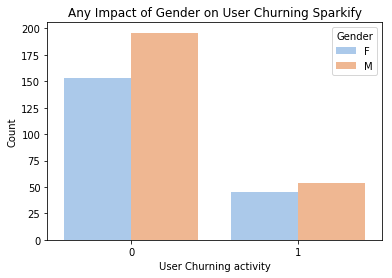

In [51]:
sns.barplot(data=gender_pd_cancel,x='churn_cancel', y='count', hue='gender', palette='pastel')
plt.xlabel('User Churning activity')
plt.ylabel('Count')
plt.legend(title='Gender', loc='best')
plt.title('Any Impact of Gender on User Churning Sparkify');

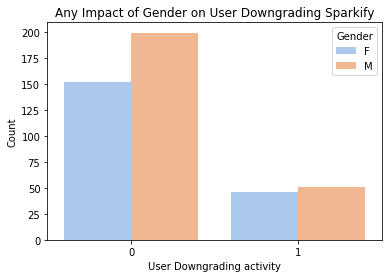

In [52]:
# gender impact on user downgrading
gender_pd_downgrade = df_label.dropDuplicates(['userId']).groupBy(['churn_downgrade', 'gender']).count().toPandas()
sns.barplot(data=gender_pd_downgrade,x='churn_downgrade', y='count', hue='gender', palette='pastel')
plt.xlabel('User Downgrading activity')
plt.ylabel('Count')
plt.legend(title='Gender', loc='best')
plt.title('Any Impact of Gender on User Downgrading Sparkify');

**Impact of user level on churning activity**

In [53]:
# when user confirmed the cancelling, the level of the user
level_pd_cancel = df_label.where(df_label.page == 'Cancellation Confirmation').groupBy('level').count().toPandas()
level_pd_cancel.head()

,level,count
0,free,32
1,paid,67


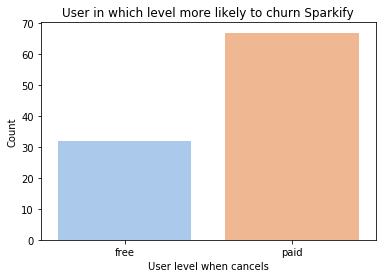

In [54]:
# barplot based on user level when user cancelling
sns.barplot(data=level_pd_cancel, x='level', y='count', palette='pastel')
plt.xlabel('User level when cancels')
plt.ylabel('Count')
plt.title('User in which level more likely to churn Sparkify');

**Impact of location of user on churning activity**

In [55]:
# location impact on user cancelling Sparkify
state_pd_cancel = df_label.where(df_label.page == 'Cancellation Confirmation').groupBy('state').count().toPandas()
state_pd_cancel.head()

,state,count
0,PA-NJ,2
1,WA,2
2,DC-VA-MD-WV,1
3,AL,2
4,NM,2


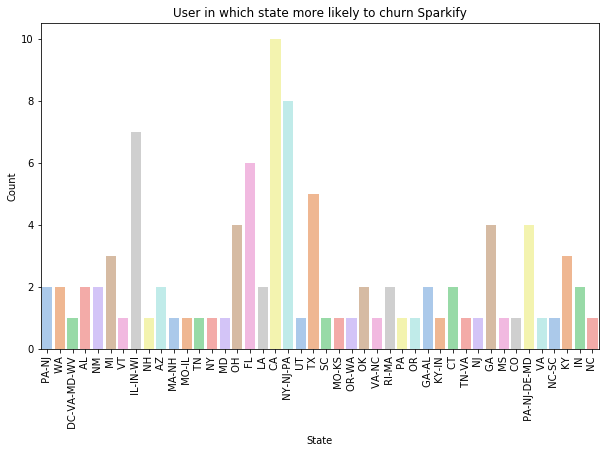

In [56]:
# barplot based on users' location 
plt.figure(figsize=(10, 6))
sns.barplot(data=state_pd_cancel, x='state', y='count', palette='pastel')
plt.xlabel('State')
plt.ylabel('Count')
plt.title('User in which state more likely to churn Sparkify')
plt.xticks(rotation = 90);

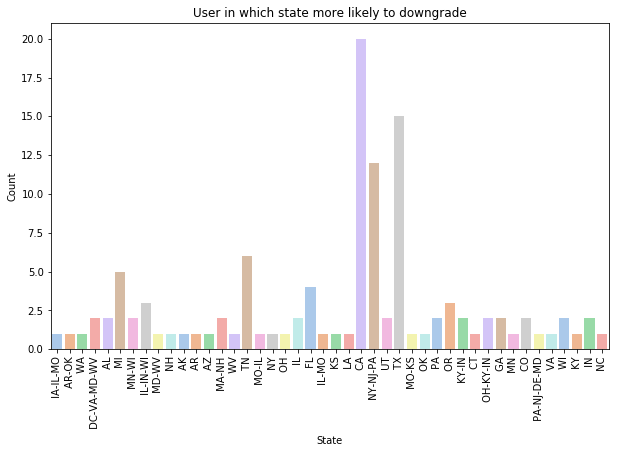

In [57]:
# location impact on user downgrading
state_pd_downgrade = df_label.where(df_label.page == 'Submit Downgrade').groupBy('state').count().toPandas()
plt.figure(figsize=(10, 6))
sns.barplot(data=state_pd_downgrade, x='state', y='count', palette='pastel')
plt.xlabel('State')
plt.ylabel('Count')
plt.title('User in which state more likely to downgrade')
plt.xticks(rotation = 90);

**User activity - How many song played per session?**

In [81]:
# get the average number of songs played in each session for each user 
song_pd_cancel = df_label.where(df_label.page == 'NextSong').groupBy(['userId', 'sessionId', 'churn_cancel','level']).count().toPandas()
song_pd_cancel.head()

,userId,sessionId,churn_cancel,level,count
0,100010,62,1,free,49
1,100010,166,1,free,47
2,200002,2,1,free,40
3,200002,91,1,free,42
4,200002,164,1,free,22


In [87]:
# https://stackoverflow.com/questions/10373660/converting-a-pandas-groupby-output-from-series-to-dataframe
song_pd_cancel_plot = song_pd_cancel.groupby(['churn_cancel', 'level', 'userId']).agg({'count': 'mean'}).reset_index()
song_pd_cancel_plot.head()

,churn_cancel,level,userId,count
0,0,free,100,23.0
1,0,free,100002,8.0
2,0,free,100006,65.0
3,0,free,100007,66.0
4,0,free,100009,106.6


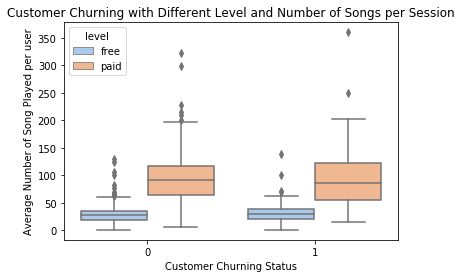

In [92]:
# boxplot for the distribution of average number of songs for different user group
sns.boxplot(data=song_pd_cancel_plot, x='churn_cancel', y='count', hue='level', palette='pastel')
plt.xlabel('Customer Churning Status')
plt.ylabel('Average Number of Song Played per user')
plt.title('Customer Churning with Different Level and Number of Songs per Session');

Index(['churn_downgrade', 'level', 'userId', 'count'], dtype='object')


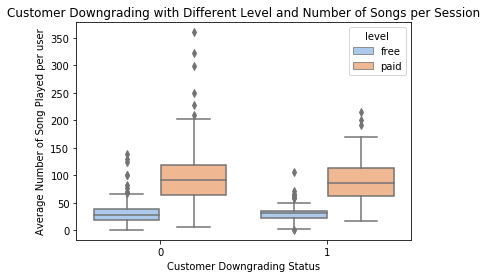

In [93]:
# get the average number of songs played in each session for each user 
song_pd_downgrade = df_label.where(df_label.page == 'NextSong').groupBy(['userId', 'sessionId', 'churn_downgrade','level']).count().toPandas()\
                    .groupby(['churn_downgrade', 'level', 'userId']).agg({'count': 'mean'}).reset_index()

# boxplot for the distribution of average number of songs for different user group
print(song_pd_downgrade.columns)
sns.boxplot(data=song_pd_downgrade, x='churn_downgrade', y='count', hue='level', palette='pastel')
plt.xlabel('Customer Downgrading Status')
plt.ylabel('Average Number of Song Played per user')
plt.title('Customer Downgrading with Different Level and Number of Songs per Session');

**User Activity: The number of Thumbs Up per session**  

Since thumbs up lies in the third place in the page values, we would like to see its impact on customer churn. Whether active user(more thumbs up per session) are likely to churn(or downgrade) or not?

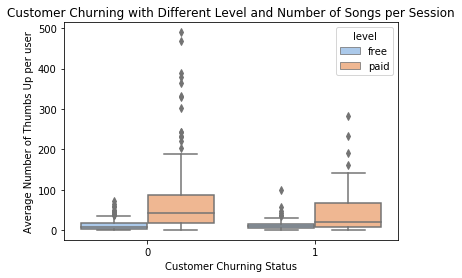

In [95]:
# get the average number of thumbs up in each session for each user 
thumbup_pd_cancel = df_label.where(df_label.page == 'Thumbs Up').groupBy(['userId', 'sessionId', 'churn_cancel','level']).count().toPandas()\
                    .groupby(['churn_cancel', 'level', 'userId']).agg({'count': 'sum'}).reset_index()

# boxplot for the distribution of average number of songs for different user group
sns.boxplot(data=thumbup_pd_cancel, x='churn_cancel', y='count', hue='level', palette='pastel')
plt.xlabel('Customer Churning Status')
plt.ylabel('Average Number of Thumbs Up per user')
plt.title('Customer Churning with Different Level and Number of Songs per Session');

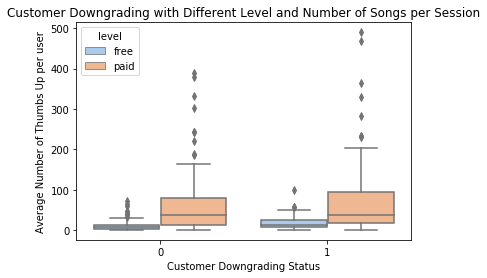

In [96]:
# get the average number of thumbs up in each session for each user 
thumbup_pd_dg = df_label.where(df_label.page == 'Thumbs Up').groupBy(['userId', 'sessionId', 'churn_downgrade','level']).count().toPandas()\
                    .groupby(['churn_downgrade', 'level', 'userId']).agg({'count': 'sum'}).reset_index()

# boxplot for the distribution of average number of songs for different user group
sns.boxplot(data=thumbup_pd_dg, x='churn_downgrade', y='count', hue='level', palette='pastel')
plt.xlabel('Customer Downgrading Status')
plt.ylabel('Average Number of Thumbs Up per user')
plt.title('Customer Downgrading with Different Level and Number of Songs per Session');

**Loyal customers or new customers?**

Wheather the loyal customers more likely to churn(or downgrade) or not?

In [111]:
# get the lifetime(time since registration) of each user 
# https://www.datasciencemadesimple.com/get-difference-between-two-dates-in-days-years-months-and-quarters-in-pyspark/
# https://sparkbyexamples.com/spark/spark-current-date-and-timestamp/
regis_pd_cancel = df_label.dropDuplicates(['userId', 'registration_date']).select(['userId', 'registration_date', 'churn_cancel'])\
                  .withColumn('current_date', current_date())\
                  .withColumn('lifetime_days', datediff(col('current_date'),col('registration_date'))).toPandas() 

regis_pd_cancel.head()

,userId,registration_date,churn_cancel,current_date,lifetime_days
0,100010,2018-09-27,1,2020-12-01,796
1,200002,2018-09-06,1,2020-12-01,817
2,296,2018-09-14,1,2020-12-01,809
3,125,2018-08-01,0,2020-12-01,853
4,124,2018-07-22,1,2020-12-01,863


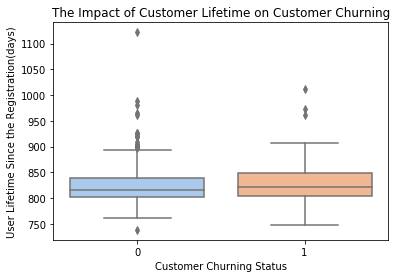

In [113]:
# boxplot for the distribution of lifetime for different user group
sns.boxplot(data=regis_pd_cancel, x='churn_cancel', y='lifetime_days', palette='pastel')
plt.xlabel('Customer Churning Status')
plt.ylabel('User Lifetime Since the Registration(days)')
plt.title('The Impact of Customer Lifetime on Customer Churning');

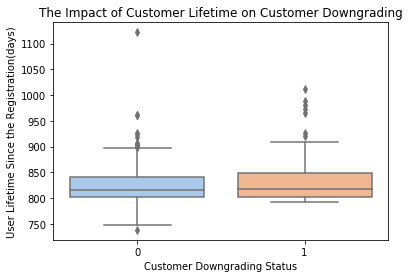

In [114]:
# get the lifetime(time since registration) of each user 
regis_pd_dg = df_label.dropDuplicates(['userId', 'registration_date']).select(['userId', 'registration_date', 'churn_downgrade'])\
                  .withColumn('current_date', current_date())\
                  .withColumn('lifetime_days', datediff(col('current_date'),col('registration_date'))).toPandas() 

# boxplot for the distribution of lifetime for different user group
sns.boxplot(data=regis_pd_dg, x='churn_downgrade', y='lifetime_days', palette='pastel')
plt.xlabel('Customer Downgrading Status')
plt.ylabel('User Lifetime Since the Registration(days)')
plt.title('The Impact of Customer Lifetime on Customer Downgrading');

In a summary：  
1. Active customers(more songs listed, thrumbs up...) tend to be more present on the Sparkify than churned customers;   
2. Churned customers have some different customer behavior when compared with downgraded customers;   
3. The lifetime and location of the customer could be indicators of customer churn.

# Feature Engineering 

After data analysis, we become more familiarized with data and figure out the interesting features to train our prediction model later. It's time to extract those features from the dataset and get ready for build out the model. 

In [117]:
# convert gender into numerical feature
f1 = df_label.dropDuplicates(['userId']).select(['userId','gender']).replace(['M','F'], ['1', '0'])
f1 = f1.withColumn('gender', f1.gender.cast('int'))
f1.show()

+------+------+
|userId|gender|
+------+------+
|100010|     0|
|200002|     1|
|   296|     0|
|   125|     1|
|   124|     0|
|    51|     1|
|     7|     1|
|200037|     1|
|   169|     1|
|   205|     0|
|   272|     0|
|    15|     1|
|   232|     0|
|   234|     1|
|   282|     1|
|    54|     0|
|   155|     0|
|200043|     0|
|100014|     1|
|   132|     0|
+------+------+
only showing top 20 rows



In [118]:
# convert level into numerical feature
f2 = df_label.dropDuplicates(['userId']).select(['userId','level']).replace(['paid','free'], ['1', '0'])
f2 = f2.withColumn('level', f2.level.cast('int'))
f2.show()

+------+-----+
|userId|level|
+------+-----+
|100010|    0|
|200002|    0|
|   296|    0|
|   125|    0|
|   124|    1|
|    51|    1|
|     7|    0|
|200037|    0|
|   169|    0|
|   205|    1|
|   272|    0|
|    15|    1|
|   232|    0|
|   234|    0|
|   282|    0|
|    54|    1|
|   155|    1|
|200043|    0|
|100014|    1|
|   132|    0|
+------+-----+
only showing top 20 rows



In [122]:
# extract the number of song played per session feature
f3 = df_label.where(df_label.page == 'NextSong').groupBy(['userId', 'sessionId']).count() \
     .groupby(['userId']).agg({'count': 'avg'}).withColumnRenamed('avg(count)', 'avg_songs_played')
f3.describe().show()

+-------+------------------+-----------------+
|summary|            userId| avg_songs_played|
+-------+------------------+-----------------+
|  count|               448|              448|
|   mean| 67520.34821428571| 65.6116840997681|
| stddev|105964.58428485192|39.49496566617267|
|    min|                10|              1.0|
|    max|                99|            360.0|
+-------+------------------+-----------------+



In [121]:
# extract the number of total song listened
f4 = df_label.select('userId', 'song').groupBy('userId').count().withColumnRenamed('count', 'total_songs')
f4.describe().show()

+-------+------------------+------------------+
|summary|            userId|       total_songs|
+-------+------------------+------------------+
|  count|               448|               448|
|   mean| 67520.34821428571|1178.5825892857142|
| stddev|105964.58428485192|1380.6279647524045|
|    min|                10|                 3|
|    max|                99|              9767|
+-------+------------------+------------------+



In [123]:
# extract the number of Thumbs Up feature 
f5 = df_label.select('userId', 'page').where(df_label.page == 'Thumbs Up').groupBy('userId').count().withColumnRenamed('count', 'num_thumbs_up')
f5.describe().show()

+-------+-----------------+-----------------+
|summary|           userId|    num_thumbs_up|
+-------+-----------------+-----------------+
|  count|              439|              439|
|   mean|67308.81548974942|54.27334851936219|
| stddev|106228.8040825479| 69.9413517877898|
|    min|               10|                1|
|    max|               99|              506|
+-------+-----------------+-----------------+



In [124]:
# extract the number of add to playlist feature
f6 = df_label.select('userId','page').where(df_label.page == 'Add to Playlist').groupBy('userId').count().withColumnRenamed('count', 'num_add_playlist')
f6.describe().show()

+-------+------------------+------------------+
|summary|            userId|  num_add_playlist|
+-------+------------------+------------------+
|  count|               428|               428|
|   mean| 65764.93457943926|28.852803738317757|
| stddev|105363.38578382804| 33.91309069456629|
|    min|                10|                 1|
|    max|                99|               248|
+-------+------------------+------------------+



In [125]:
# extract the number of add to playlist feature
f7 = df_label.select('userId','page').where(df_label.page == 'Add Friend').groupBy('userId').count().withColumnRenamed('count', 'num_add_friend')
f7.describe().show()

+-------+------------------+------------------+
|summary|            userId|    num_add_friend|
+-------+------------------+------------------+
|  count|               409|               409|
|   mean|  66368.3716381418|19.772616136919314|
| stddev|106064.01609030597|22.494435766272833|
|    min|                10|                 1|
|    max|                99|               158|
+-------+------------------+------------------+



In [126]:
# extract the number of artists listened feature
f8 = df_label.where(df_label.page == 'NextSong').select('userId','artist').dropDuplicates() \
     .groupBy('userId').count().withColumnRenamed('count', 'num_artists')
f8.describe().show()

+-------+------------------+-----------------+
|summary|            userId|      num_artists|
+-------+------------------+-----------------+
|  count|               448|              448|
|   mean| 67520.34821428571|658.9799107142857|
| stddev|105964.58428485192| 625.882698051957|
|    min|                10|                1|
|    max|                99|             3507|
+-------+------------------+-----------------+



In [136]:
# extract the lifetime of customers since they join the Sparkify
f9 = df_label.select(['userId', 'registration_date'])\
      .withColumn('current_date', current_date())\
      .withColumn('lifetime_days', datediff(col('current_date'),col('registration_date')))\
      .groupBy('userId').agg({'lifetime_days':'max'})\
      .withColumnRenamed('max(lifetime_days)','lifetime_days')
f9.describe().show()

+-------+------------------+-----------------+
|summary|            userId|    lifetime_days|
+-------+------------------+-----------------+
|  count|               448|              448|
|   mean| 67520.34821428571|830.3705357142857|
| stddev|105964.58428485192|37.60177809683291|
|    min|                10|              741|
|    max|                99|             1125|
+-------+------------------+-----------------+



In [137]:
# add the churn label
label = df_label.select(['userId', 'churn_cancel']).distinct().withColumnRenamed('churn_cancel', 'label')
label.describe().show()

+-------+------------------+-------------------+
|summary|            userId|              label|
+-------+------------------+-------------------+
|  count|               448|                448|
|   mean| 67520.34821428571|0.22098214285714285|
| stddev|105964.58428485192|0.41537231043963646|
|    min|                10|                  0|
|    max|                99|                  1|
+-------+------------------+-------------------+



In [138]:
#combine all features into final dataframe to be used for model
df_final = f1.join(f2,'userId','outer') \
            .join(f3,'userId','outer') \
            .join(f4,'userId','outer') \
            .join(f5,'userId','outer') \
            .join(f6,'userId','outer') \
            .join(f7,'userId','outer') \
            .join(f8,'userId','outer') \
            .join(f9,'userId','outer') \
            .join(label,'userId','outer') \
            .drop('userId') \
            .fillna(0)
df_final.show(2)

+------+-----+----------------+-----------+-------------+----------------+--------------+-----------+-------------+-----+
|gender|level|avg_songs_played|total_songs|num_thumbs_up|num_add_playlist|num_add_friend|num_artists|lifetime_days|label|
+------+-----+----------------+-----------+-------------+----------------+--------------+-----------+-------------+-----+
|     0|    0|            48.0|        137|            4|               1|             3|         94|          799|    1|
|     1|    0|            62.0|        395|           15|               6|             2|        287|          820|    1|
+------+-----+----------------+-----------+-------------+----------------+--------------+-----------+-------------+-----+
only showing top 2 rows



# Modeling   

Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods. Evaluate the accuracy of the those models, tuning parameters as necessary.

Since the churned users are a fairly small subset, we use F1 score as the metric to optimize The reason we use F-1 score here is because it gives us a simple measure of the precision (whether we send offer to the right person) and recall (whether we miss one that we should’ve sent the offer) of the model. We want to identify those who are likely to churn and give them some special offers in trying to keep the customer, but at the same time, we do not want to send too many offers (most likely a monetary incentive) to those who are not as likely to churn and therefore wasting money and resources.

In [140]:
# create the vector assembler
inputcols = ['gender', 'level', 'avg_songs_played', 'total_songs', 'num_thumbs_up', 'num_add_playlist', 
             'num_add_friend', 'num_artists', 'lifetime_days']
assembler = VectorAssembler(inputCols=inputcols, outputCol='featurevectors')
data = assembler.transform(df_final)

In [141]:
# standardize the features by standard scaler
scaler = StandardScaler(inputCol='featurevectors', outputCol='features', withStd=True)
scalerModel = scaler.fit(data)
data = scalerModel.transform(data)

In [142]:
# split the data into train, validation and test data
train, rest = data.randomSplit([0.6, 0.4], seed=42)
validation, test = rest.randomSplit([0.5, 0.5], seed=42)

In [143]:
# the churned users are a fairly small subset,even if the model predict all user as no churning user, the accuracy and f1 score will not lower
# calculate the accuracy and f1 score
result_all_0 = test.withColumn('prediction', lit(0.0))
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print(f'Accuracy: {(evaluator.evaluate(result_all_0, {evaluator.metricName: "accuracy"}))}')
print(f'F-1 Score:{(evaluator.evaluate(result_all_0, {evaluator.metricName: "f1"}))}')

Accuracy: 0.752
F-1 Score:0.645552511415525


**Logistic Regression**

In [146]:
# initialize classifier
lr = LogisticRegression(maxIter=10)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder().build()

crossval_lr = CrossValidator(estimator=lr,
                             evaluator=f1_evaluator, 
                             estimatorParamMaps=paramGrid,
                             numFolds=3)
# fit model with train data
cvModel_lr = crossval_lr.fit(train)
cvModel_lr.avgMetrics
# predict on test data
predict_lr = cvModel_lr.transform(validation)
# evaluate the model performance
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction')
print(f'Accuracy: {(evaluator.evaluate(predict_lr, {evaluator.metricName: "accuracy"}))}')
print(f'F-1 Score:{(evaluator.evaluate(predict_lr, {evaluator.metricName: "f1"}))}')

Accuracy: 0.7636363636363637
F-1 Score:0.6770384254920337


**Random Forest**

In [147]:
# initialize classifier
rf = RandomForestClassifier()

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder().build()

crossval_rf = CrossValidator(estimator=rf,
                             estimatorParamMaps=paramGrid,
                             evaluator=f1_evaluator,
                             numFolds=3)
# fit model
cvModel_rf = crossval_rf.fit(train)
cvModel_rf.avgMetrics
# predict on test data
predict_rf = cvModel_rf.transform(validation)

# evaluate the model performance
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print(f'Accuracy: {(evaluator.evaluate(predict_rf, {evaluator.metricName: "accuracy"}))}')
print(f'F-1 Score:{(evaluator.evaluate(predict_rf, {evaluator.metricName: "f1"}))}')

Accuracy: 0.7818181818181819
F-1 Score:0.6860853432282005


**[Gradient Boosted Trees](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.classification.GBTClassifier)**

In [148]:
# initialize classifier
gbt = GBTClassifier(maxIter=10,seed=42)

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

# build paramGrid
paramGrid = ParamGridBuilder().build()

crossval_gbt = CrossValidator(estimator=gbt,
                              estimatorParamMaps=paramGrid,
                              evaluator=f1_evaluator,
                              numFolds=3)
# fit model
cvModel_gbt = crossval_gbt.fit(train)
cvModel_gbt.avgMetrics
# predict on test data
predict_gbt = cvModel_gbt.transform(validation)

# evaluate the model performance
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

print(f'Accuracy: {(evaluator.evaluate(predict_gbt, {evaluator.metricName: "accuracy"}))}')
print(f'F-1 Score:{(evaluator.evaluate(predict_gbt, {evaluator.metricName: "f1"}))}')

Accuracy: 0.8181818181818182
F-1 Score:0.7627164502164503


**Summary:**      

- Since the churned customers are in a small amount of the data, even if we predicted all the customer as loyal customers(no churning), the accuracy is 0.752 and the F1 score is 0.646;   
- The highest accuracy among three models is 0.818, and the highest F1 score among three models is 0.763. They are both from the gradient boosted trees model;   
- Compared to the baseline prediction, the accuracy of the gradient boosted trees model increased 9% and the F1 score of the it increased 18%.   

Based on the final prediction results, we choose gradient boosted trees as our final model for further tuning and prediction.

**Hyperparameters Tuning**   

We will use the grid search to tune the gradient boosted trees model.We mainly focus on two parameters this time, maxIter and maxDepth.

In [163]:
# initialize classifier
gbt_tune = GBTClassifier(seed=42)
# create paramGrid
gbt_paramGrid = ParamGridBuilder().addGrid(gbt_tune.maxDepth,[3, 5, 10]).addGrid(gbt_tune.maxIter, [5, 10, 20]).build()

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

crossval_gbt_tune = CrossValidator(estimator=gbt_tune,
                                   estimatorParamMaps=gbt_paramGrid,
                                   evaluator=f1_evaluator,
                                   numFolds=3)

In [164]:
cvModel_gbt_tune = crossval_gbt_tune.fit(train)
cvModel_gbt_tune.avgMetrics

[0.7209955061442092,
 0.7286822180911616,
 0.7102604501690608,
 0.7216477426919934,
 0.7166597773847029,
 0.7105132547640091,
 0.663602771814154,
 0.6669540246522365,
 0.6601819177552662]

In [165]:
predict_gbt_tune = cvModel_gbt_tune.bestModel.transform(test)
# evaluate the model performance
gbt_tuned_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Metrics of Tuned GBT Model:')
print(f'Accuracy: {(gbt_tuned_evaluator.evaluate(predict_gbt_tune, {gbt_tuned_evaluator.metricName: "accuracy"}))}')
print(f'F-1 Score:{(gbt_tuned_evaluator.evaluate(predict_gbt_tune, {gbt_tuned_evaluator.metricName: "f1"}))}')

Metrics of Tuned GBT Model:
Accuracy: 0.728
F-1 Score:0.6463011422637591


In [166]:
# the parmeters of the best GBT model
cvModel_gbt_tune.bestModel.extractParamMap()

{Param(parent='GBTClassifier_f51911c0967e', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval.'): False,
 Param(parent='GBTClassifier_f51911c0967e', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext.'): 10,
 Param(parent='GBTClassifier_f51911c0967e', name='featureSubsetStrategy', doc="The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for r